# Formula 1 Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, plot_roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score)
import joblib

In [ ]:
#warning this takes 287 minutes to run!!!
# thats over 6 hours
file='./data/clean/combined_ergast_clean.csv'
qualify_df=pull_clean_aggregate_telemetry(file)

In [96]:
# save the dataframe
#qualify_df.to_pickle('./data/model_data/formula1_complete_2018_2022_updated_301022.pkl',compression='gzip')

In [97]:
qualify_df_1=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_update291022.pkl',compression='gzip')

In [98]:
print(f'The complete database has this many nan rows {qualify_df_1.isna().any(axis=1).sum()}')
print(f'The nans are {round(qualify_df_1.isna().any(axis=1).sum()/len(qualify_df_1),2)}% of the data')

The complete database has this many nan rows 46
The nans are 0.02% of the data


These nans come from lack of car telemetry data. Who has the most Nan's?

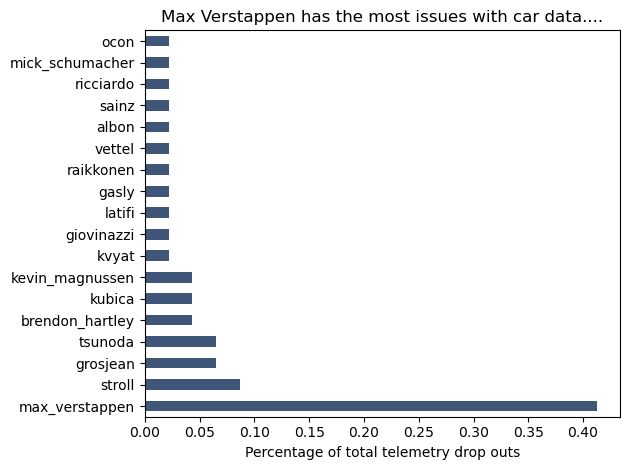

In [4]:
per_nan = qualify_df_1.loc[(qualify_df_1.isna().any(axis=1)),'driverRef'].value_counts()/len(qualify_df.loc[(qualify_df.isna().any(axis=1))])
plt.figure()
per_nan.plot(kind='barh')
plt.title('Max Verstappen has the most issues with car data....')
plt.xlabel('Percentage of total telemetry drop outs')
plt.tight_layout()
plt.savefig('./images/verstappend_nans.jpg',dpi=300)
plt.show()

In [2]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_updated_301022.pkl',compression='gzip')

In [3]:
print(f'The complete database has this many nan rows {qualify_df.isna().any(axis=1).sum()}')
print(f'The nans are {round(qualify_df.isna().any(axis=1).sum()/len(qualify_df),2)}% of the data')

The complete database has this many nan rows 0
The nans are 0.0% of the data


In [4]:
qualifying_df=qualify_df.copy()

In [5]:
qualifying_df.dropna(inplace=True)

In [6]:
display_df=qualify_df.copy()
display_df.dropna(inplace=True)

In [7]:
display_df = convert_object_to_float(display_df)

In [8]:
display_df = engineer_target_bin(display_df)

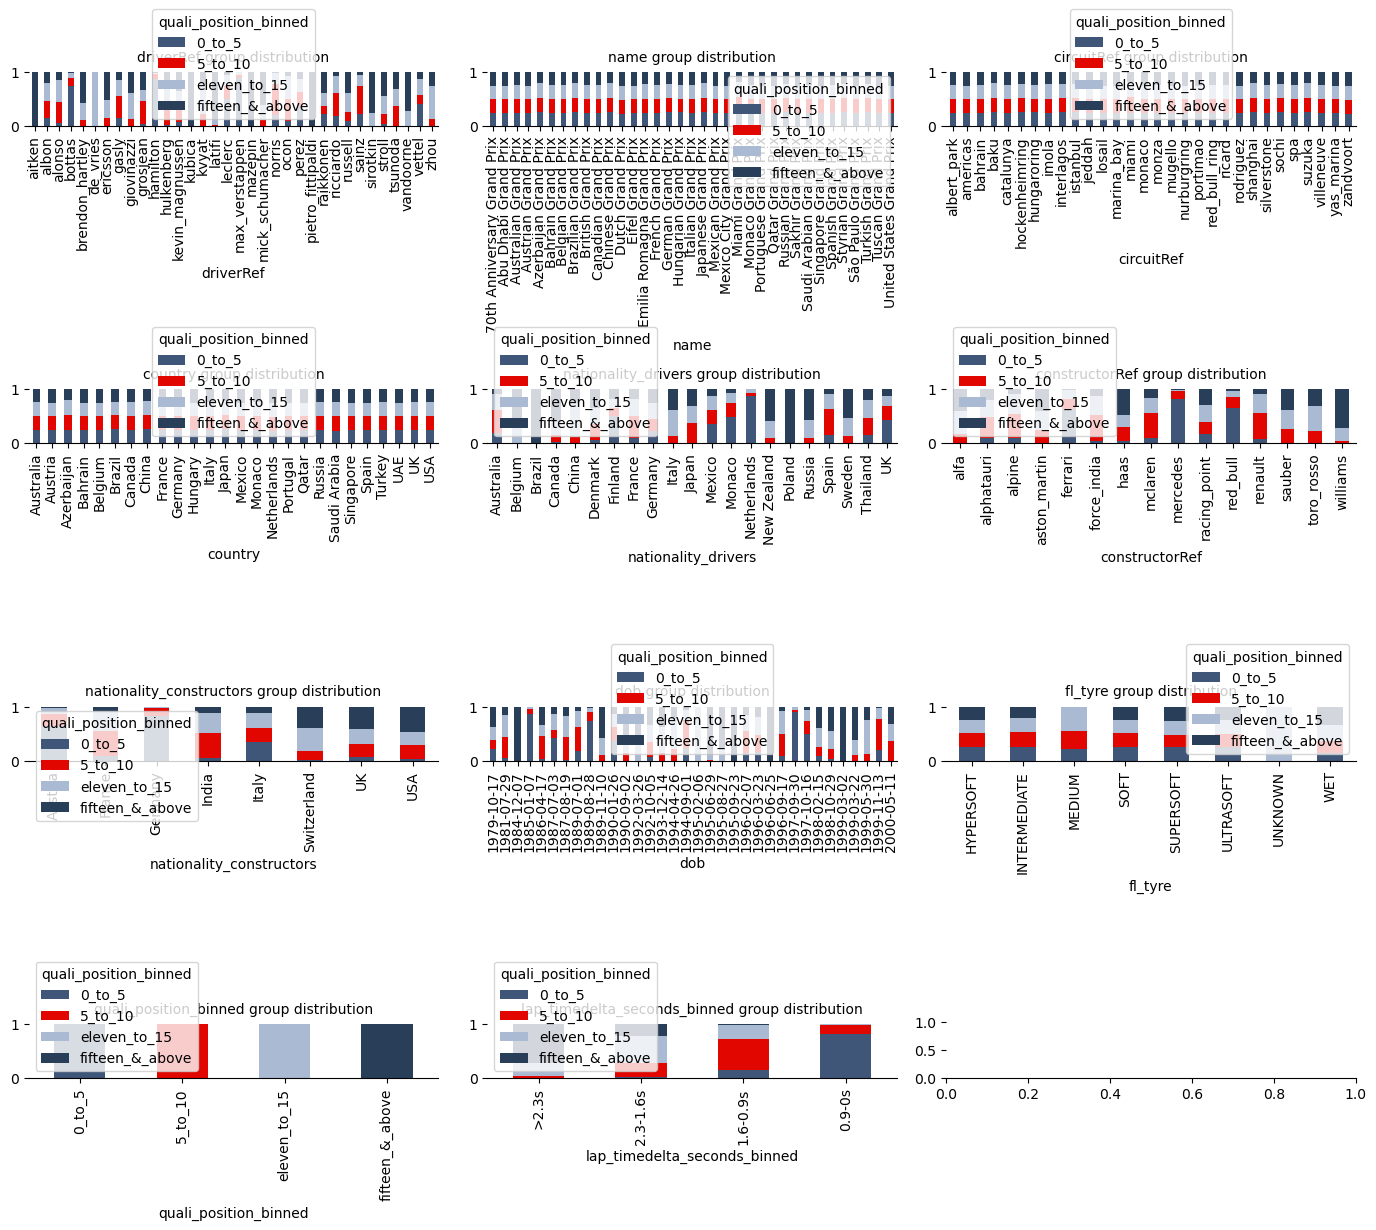

In [9]:
plot_categorical_cols_by_dim(display_df,'quali_position_binned',columns=3)

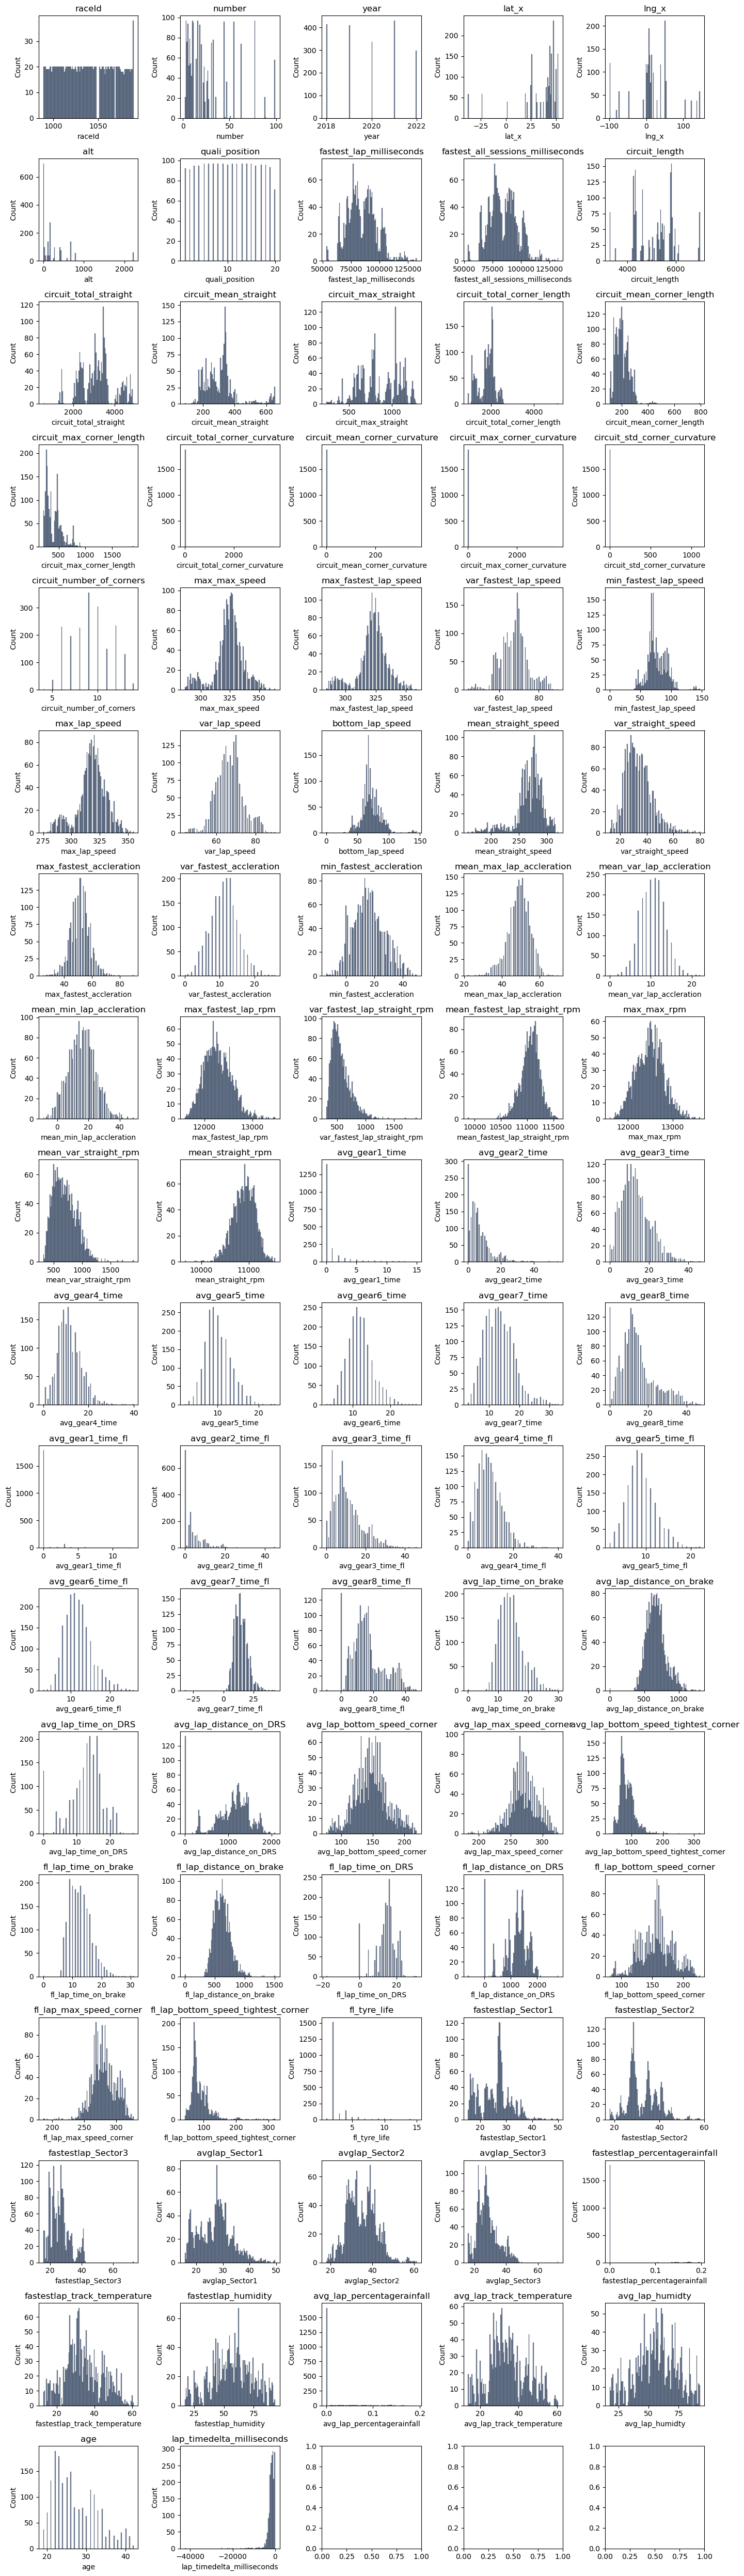

In [10]:
plot_numerical_variables_hist(display_df)

## Prepare for modelling

In [11]:
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df)

In [12]:
print(f'percentage test data is {(len(X_test)/len(X_train))*100}')

percentage test data is 11.504424778761061


In [13]:
hot_encode_col=list(X_train.select_dtypes("object").columns)
scale_cols = [col for col in X_train.columns if col not in hot_encode_col]

In [14]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
col_transform = ColumnTransformer(transformers=transformer)  
col_transform

ColumnTransformer(transformers=[('numerical_transform', StandardScaler(),
                                 ['year', 'lat_x', 'lng_x', 'alt',
                                  'circuit_length', 'circuit_total_straight',
                                  'circuit_mean_straight',
                                  'circuit_max_straight',
                                  'circuit_total_corner_length',
                                  'circuit_mean_corner_length',
                                  'circuit_max_corner_length',
                                  'circuit_total_corner_curvature',
                                  'circuit_mean_corner_curvature',
                                  'circui...
                                  'min_fastest_lap_speed', 'max_lap_speed',
                                  'var_lap_speed', 'bottom_lap_speed',
                                  'mean_straight_speed', 'var_straight_speed',
                                  'max_fastest_accleration',
                                  'var_fastest_accleration',
                                  'min_fastest_accleration',
                                  'mean_max_lap_accleration',
                                  'mean_var_lap_accleration', ...]),
                                ('hot_encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['driverRef', 'circuitRef', 'constructorRef',
                                  'fl_tyre'])])

In [15]:
X_train_scaled_demonstration = pd.DataFrame(data=col_transform.fit_transform(X_train),columns=col_transform.get_feature_names_out())
X_train_scaled_demonstration.head()

,numerical_transform__year,numerical_transform__lat_x,numerical_transform__lng_x,numerical_transform__alt,numerical_transform__circuit_length,numerical_transform__circuit_total_straight,numerical_transform__circuit_mean_straight,numerical_transform__circuit_max_straight,numerical_transform__circuit_total_corner_length,numerical_transform__circuit_mean_corner_length,...,hot_encode__constructorRef_toro_rosso,hot_encode__constructorRef_williams,hot_encode__fl_tyre_HYPERSOFT,hot_encode__fl_tyre_INTERMEDIATE,hot_encode__fl_tyre_MEDIUM,hot_encode__fl_tyre_SOFT,hot_encode__fl_tyre_SUPERSOFT,hot_encode__fl_tyre_ULTRASOFT,hot_encode__fl_tyre_UNKNOWN,hot_encode__fl_tyre_WET
0,-1.352246,-3.478974,2.36237,-0.515038,0.179075,0.126429,-0.614873,-1.042687,0.010025,-1.111108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.352246,-3.478974,2.36237,-0.515038,0.181476,0.107868,-0.792745,-1.103030,-0.039220,-1.368134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.352246,-3.478974,2.36237,-0.515038,0.183877,0.157363,-0.736575,-1.068548,-0.111793,-1.348363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.352246,-3.478974,2.36237,-0.515038,0.188680,0.125191,-0.755298,-1.090099,-0.021077,-1.249507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.352246,-3.478974,2.36237,-0.515038,0.183877,0.062086,-0.727213,-1.141822,0.124067,-1.130879,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
ydelta_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
ydelta_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])

In [17]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
ypos_train= labelencoder.transform(y_train['quali_position_binned'])
ypos_test= labelencoder.transform(y_test['quali_position_binned'])

## Find Important Features

### Random Forest Feature Importance

In [18]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [19]:
rf_model= forest_pipe.fit(X_train,ypos_train)

In [20]:
RF_results = pd.DataFrame(data=rf_model['random_forest'].feature_importances_ ,index=rf_model['column_transform'].get_feature_names_out())

In [21]:
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

In [22]:
RF_results.to_pickle('./data/model_data/feature_importance_random_forest.pkl')

### Select K best feature importance

In [23]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

select_k_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('select_k',SelectKBest())# classifier
        
]
select_pipe=Pipeline(select_k_estimator)

In [24]:
sel_model=select_pipe.fit(X_train,ypos_train)

In [25]:
select_results = pd.DataFrame(data=sel_model['select_k'].scores_ ,index=sel_model['column_transform'].get_feature_names_out())
select_results.rename(columns={0:'SelectKbest_result'},inplace=True)

### PCA feature importance

In [26]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

pca_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('pca',PCA(n_components=0.9))# classifier
        
]
pca_pipe=Pipeline(pca_estimator)

In [27]:
pca_model=pca_pipe.fit(X_train,ypos_train)

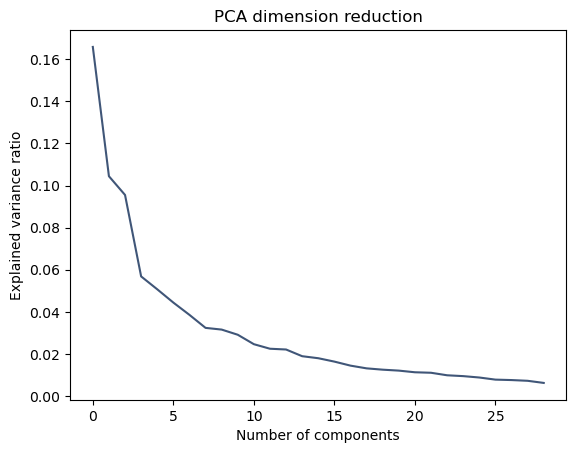

In [28]:
plt.figure()
plt.plot(np.arange(0,pca_model['pca'].n_components_,1),pca_model['pca'].explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')
plt.title('PCA dimension reduction')
plt.show()

In [29]:
len(pca_model['pca'].explained_variance_)

29

## Feature Importance

In [30]:
pca_results = pd.DataFrame(data=pca_model['pca'].components_[0:2],columns=pca_model['column_transform'].get_feature_names_out(),index=['PCA1','PCA2'])

In [31]:
all_results = pd.concat([RF_results,select_results,pca_results.T.abs()],axis=1)
scaler=StandardScaler()
all_results_scaled = scaler.fit_transform(all_results)
all_results_2 = pd.DataFrame(data=all_results_scaled,index=all_results.index,columns=all_results.columns)

In [32]:
all_results_2.to_pickle('./data/model_data/feature_importance_results.pkl')

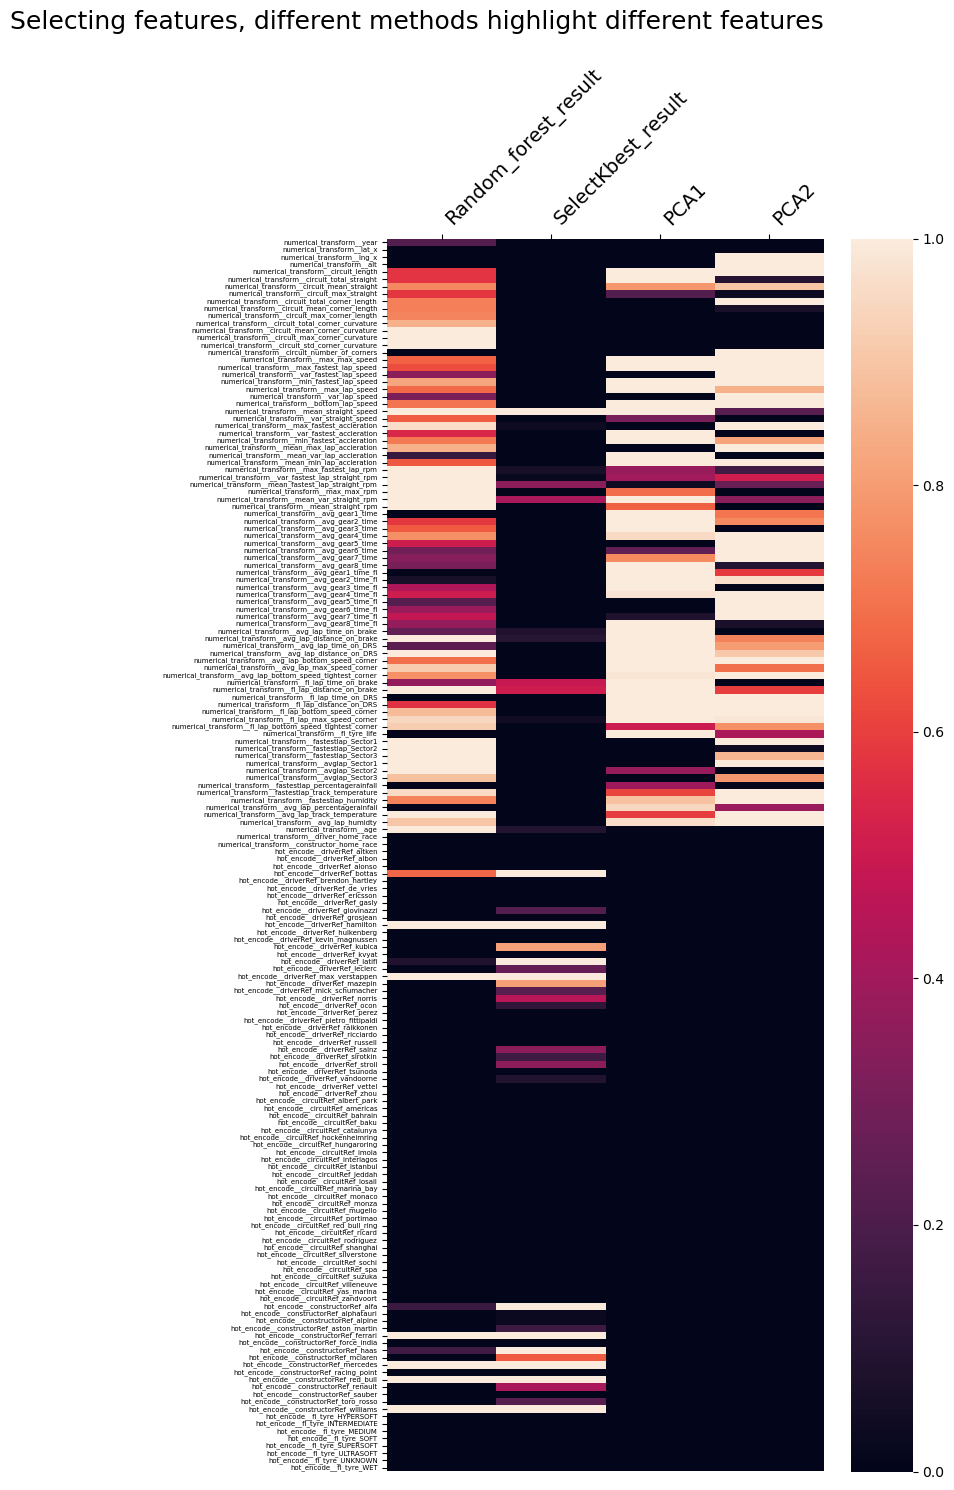

In [33]:
plt.figure(figsize=(8,15))
sns.heatmap(all_results_2, vmax=1, vmin=0)

plt.gca().xaxis.tick_top()
plt.title('Selecting features, different methods highlight different features\n',loc='right',fontsize=18)
plt.xticks(rotation = 45,ha='left',fontsize=14)
plt.yticks(np.arange(0.5,(len(all_results_2.index)+0.5)),labels=all_results_2.index,va="center",fontsize=5)
#plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('./images/feature_selection_all_data_full_v2.jpg',dpi=300,bbox_inches='tight')
plt.show()

In [34]:
print(f'Vanilla starting Random Forest Score is {rf_model.score(X_test,ypos_test)}')

Vanilla starting Random Forest Score is 0.558974358974359


## Baseline Logisitic Regression Model

### Manually Selected Features

In [36]:
RF_results['Random_forest_result'].mean()*1.75

0.010355029585798816

<Figure size 640x480 with 0 Axes>

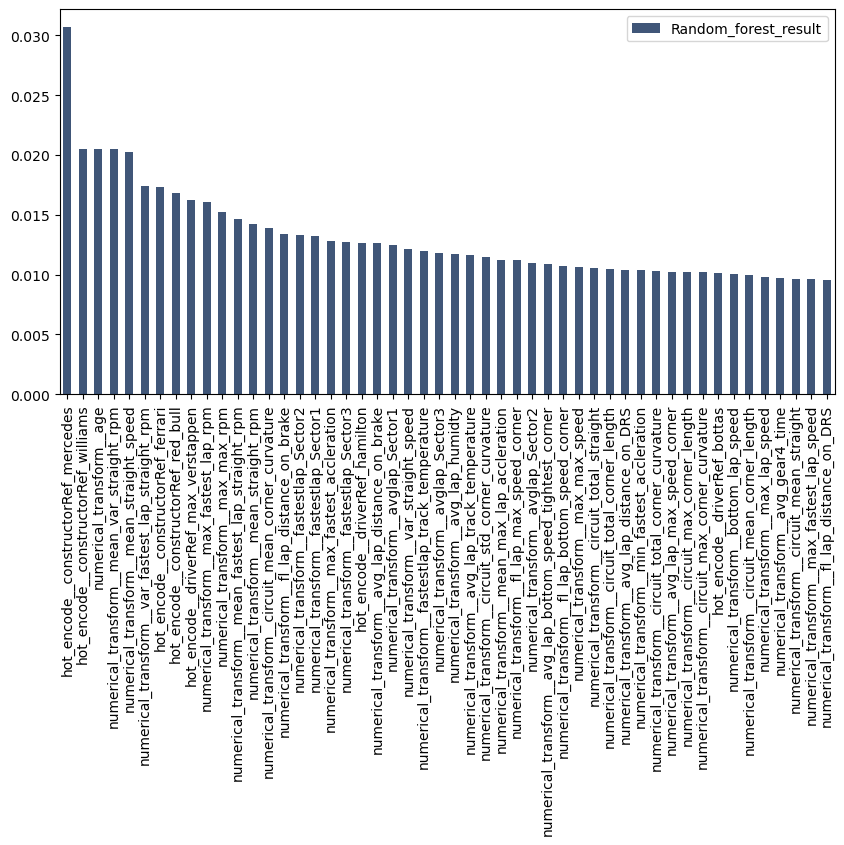

In [37]:
plt.figure()
RF_results.sort_values(by='Random_forest_result',ascending=False).head(50).plot(kind='bar',figsize=(10,5))
plt.show()

In [38]:
RF_results[RF_results['Random_forest_result'] > RF_results['Random_forest_result'].mean()*1.75].sort_values(by='Random_forest_result',ascending=False)

,Random_forest_result
hot_encode__constructorRef_mercedes,0.030666
hot_encode__constructorRef_williams,0.020526
numerical_transform__age,0.020508
numerical_transform__mean_var_straight_rpm,0.020476
numerical_transform__mean_straight_speed,0.020216
numerical_transform__var_fastest_lap_straight_rpm,0.017398
hot_encode__constructorRef_ferrari,0.017357
hot_encode__constructorRef_red_bull,0.016794
hot_encode__driverRef_max_verstappen,0.016209
numerical_transform__max_fastest_lap_rpm,0.016065


In [39]:
manual_features = list(RF_results[RF_results['Random_forest_result']>0.0105].index)

In [40]:
features_remove =[ 'numerical_transform__avglap_Sector1',
 'numerical_transform__avglap_Sector2',
 'numerical_transform__avglap_Sector3',
 'numerical_transform__max_max_rpm',
 'numerical_transform__mean_var_straight_rpm',
 'numerical_transform__mean_straight_rpm',
 #'hot_encode__driverRef_hamilton',
 #'hot_encode__driverRef_max_verstappen',
 #'hot_encode__constructorRef_ferrari',
 #'hot_encode__constructorRef_mercedes',
 #'hot_encode__constructorRef_red_bull',
 #'hot_encode__constructorRef_williams',
 #'hot_encode__driverRef_bottas'
 ]

In [41]:
manual_features = [x for x in manual_features if x not in features_remove]

In [42]:
len(manual_features)

30

## Manual Features

## Trying and failing in pipeline

In [30]:
all_features= col_transform.get_feature_names_out()
mask=list(np.where(np.in1d(all_features,manual_features))[0])

In [31]:
#manual_features.append('driverRef')
#manual_features.append('constructorRef')

In [32]:
#X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train)

In [33]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        #('column_selector', ColumnTransformer(transformers=selector,remainder='drop')),
        ('column_selector', ColumnSelector_BP(mask)),
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [34]:
rf_model= forest_pipe.fit(X_train,ypos_train)

In [35]:
print(f' Initial train score with selected featuers {rf_model.score(X_train,ypos_train)}')
print(f' Initial test score with selected feaure {rf_model.score(X_test,ypos_test)}')

 Initial train score with selected featuers 1.0
 Initial test score with selected feaure 0.5357142857142857


In [50]:
rf_model= forest_pipe.fit(X_train,ydelta_train)

In [51]:
print(f' Initial train score with selected featuers {rf_model.score(X_train,ydelta_train)}')
print(f' Initial test score with selected feaure {rf_model.score(X_test,ydelta_test)}')

 Initial train score with selected featuers 1.0
 Initial test score with selected feaure 0.5357142857142857


## Logisitic Regression

In [43]:
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [44]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('log_reg',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

Position Logisitic Initial train score with manual selected features 0.615339233038348
Position Logisitic Initial test score with manual selected feaures 0.5918367346938775


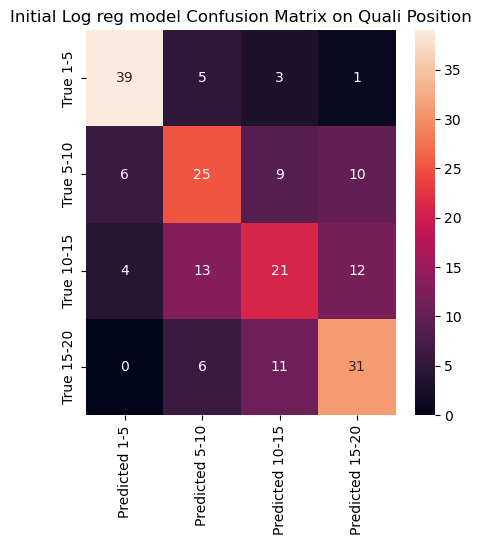

In [53]:
log_model_pos= log_pipe.fit(X_train_manual,ypos_train)
print(f'Position Logisitic Initial train score with manual selected features {log_model_pos.score(X_train_manual,ypos_train)}')
print(f'Position Logisitic Initial test score with manual selected feaures {log_model_pos.score(X_test_manual,ypos_test)}')
y_pred=log_model_pos.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 1-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 1-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Initial Log reg model Confusion Matrix on Quali Position')
plt.show()

Delta Logisitic Initial train score with manual selected features 0.6430678466076696
Delta Logisitic Initial test score with manual selected feaures 0.5816326530612245


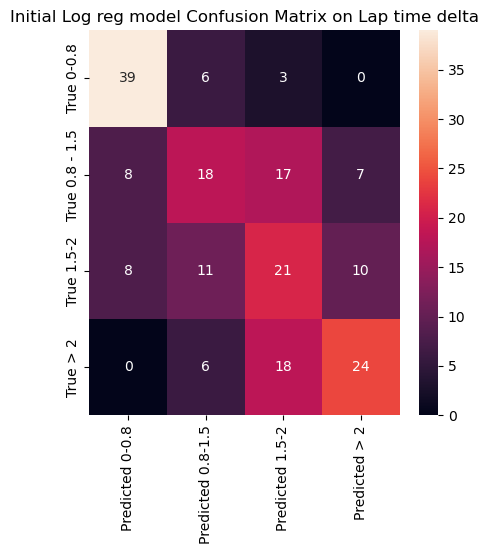

In [46]:
log_model_delta= log_pipe.fit(X_train_manual,ydelta_train)
print(f'Delta Logisitic Initial train score with manual selected features {log_model_delta.score(X_train_manual,ydelta_train)}')
print(f'Delta Logisitic Initial test score with manual selected feaures {log_model_delta.score(X_test_manual,ydelta_test)}')
y_pred=log_model_delta.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Initial Log reg model Confusion Matrix on Lap time delta')
plt.show()

## Decision Tree

In [47]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

dt_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('decision_tree',DecisionTreeClassifier(max_depth=5))# classifier
        
]
dt_pipe=Pipeline(dt_estimator)

In [48]:
dt_model_pos= dt_pipe.fit(X_train_manual,ypos_train)
print(f'Position DT Initial train score with manual selected featuers  {dt_model_pos.score(X_train_manual,ypos_train)}')
print(f'Position DT Initial test score with manual selected feaure  {dt_model_pos.score(X_test_manual,ypos_test)}')
dt_model_delta= dt_pipe.fit(X_train_manual,ydelta_train)
print(f'Lap Delta DT Initial train score with manual selected featuers  {dt_model_delta.score(X_train_manual,ydelta_train)}')
print(f'Lap Delta DT Initial test score with manual selected feaure {dt_model_delta.score(X_test_manual,ydelta_test)}')

Position DT Initial train score with manual selected featuers  0.5339233038348082
Position DT Initial test score with manual selected feaure  0.5
Lap Delta DT Initial train score with manual selected featuers  0.5533923303834808
Lap Delta DT Initial test score with manual selected feaure 0.4642857142857143


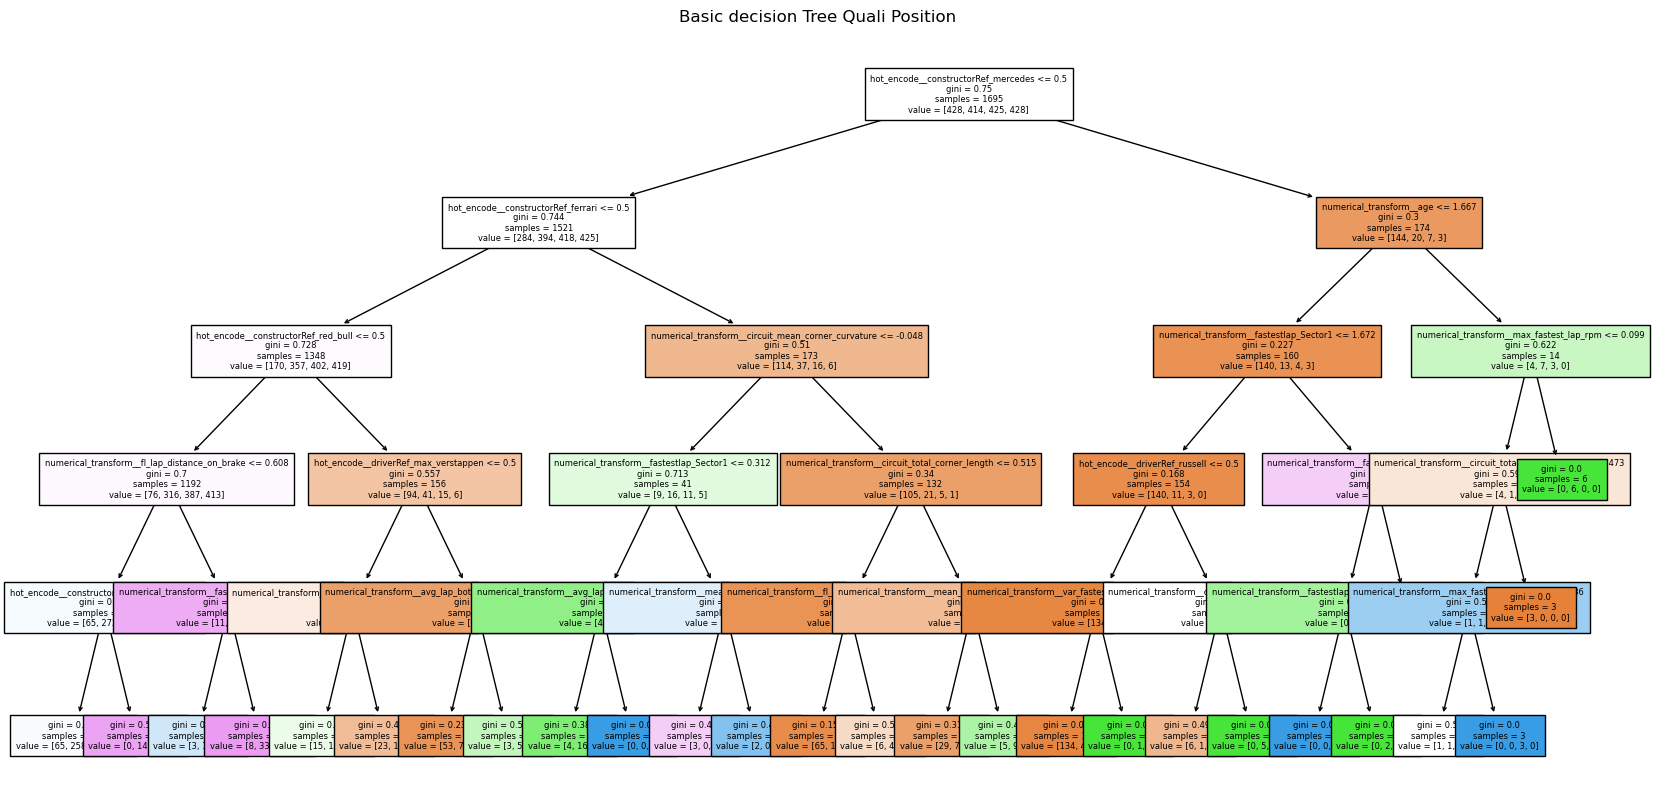

In [49]:
plt.figure(figsize=(20,10))

plot_tree(dt_model_pos.named_steps['decision_tree'],feature_names=dt_model_pos[:-1].get_feature_names_out(),filled=True, fontsize=6)
plt.title('Basic decision Tree Quali Position')
plt.show()

## PCA dimension reduction

## Logisitic Regression

In [50]:
scale_cols, hot_encode_col = column_lists(X_train)

In [51]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

Log_reg_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('pca', PCA()),
        ('log_reg',LogisticRegression())# classifier
        
]
log_reg_pipe=Pipeline(Log_reg_estimator)

In [52]:
log_reg_pipe.set_params(pca__n_components=0.9)
log_model_pos = log_reg_pipe.fit(X_train,ypos_train)
print(f'Position Log Reg Initial train score with PCA selected features {log_model_pos.score(X_train,ypos_train)}')
print(f'Position Initial test score with PCA selected feaure {log_model_pos.score(X_test,ypos_test)}')
log_model_delta= log_reg_pipe.fit(X_train,ydelta_train)
print(f'Lap Delta Log Reg Initial train score with PCA selected features {log_model_delta.score(X_train,ydelta_train)}')
print(f'Lap Delta Log Reg Initial test score with PCA selected feaure {log_model_delta.score(X_test,ydelta_test)}')

Position Log Reg Initial train score with PCA selected features 0.41887905604719766
Position Initial test score with PCA selected feaure 0.37244897959183676
Lap Delta Log Reg Initial train score with PCA selected features 0.4749262536873156
Lap Delta Log Reg Initial test score with PCA selected feaure 0.3673469387755102


## Decision Tree

In [54]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

dt_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('pca', PCA()),
        ('decision_tree',DecisionTreeClassifier(max_depth=5))# classifier
        
]
dt_pipe=Pipeline(dt_estimator)

In [55]:
dt_pipe.set_params(pca__n_components=15)
dt_model_pos= dt_pipe.fit(X_train,ypos_train)
print(f'Position DT Initial train score with PCA selected features  {dt_model_pos.score(X_train,ypos_train)}')
print(f'Position DT Initial test score with PCA selected feaures  {dt_model_pos.score(X_test,ypos_test)}')
dt_model_delta= dt_pipe.fit(X_train,ydelta_train)
print(f'Lap Delta DT Initial train score with PCA selected featuers  {dt_model_delta.score(X_train,ydelta_train)}')
print(f'Lap Delta DT Initial test score with PCA selected feaures {dt_model_delta.score(X_test,ydelta_test)}')

Position DT Initial train score with PCA selected features  0.3882005899705015
Position DT Initial test score with PCA selected feaures  0.29591836734693877
Lap Delta DT Initial train score with PCA selected featuers  0.40412979351032446
Lap Delta DT Initial test score with PCA selected feaures 0.2857142857142857


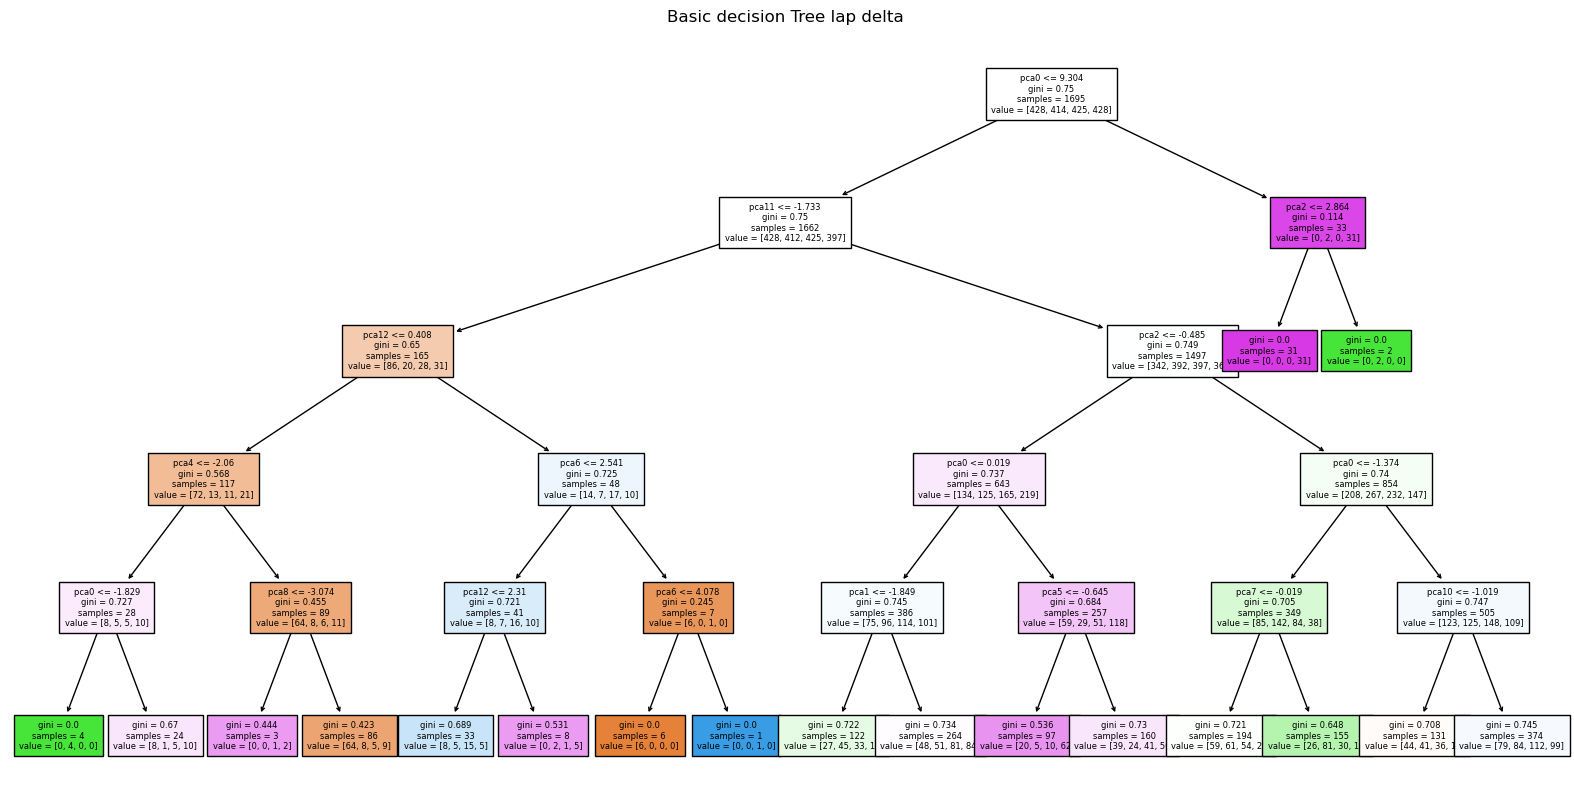

In [56]:
plt.figure(figsize=(20,10))

plot_tree(dt_model_delta.named_steps['decision_tree'],feature_names=dt_model_delta[:-1].get_feature_names_out(),filled=True, fontsize=6)
plt.title('Basic decision Tree lap delta')
plt.show()

## Optimise Logistic Regression

## Manual Selection of Features

### Qualifying position

In [57]:
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [58]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('log_reg',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

In [59]:
log_grid=[
    {
        'log_reg__solver': ['lbfgs'],
        'log_reg__penalty':['l2'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {
        'log_reg__solver': ['liblinear'],
        'log_reg__penalty':['l1'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
]

grid_log=GridSearchCV(log_pipe,log_grid,cv=5,verbose=1,return_train_score=True,n_jobs=-1)
fittedgrid_log=grid_log.fit(X_train_manual,ypos_train)

print(fittedgrid_log.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'log_reg__C': 1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}


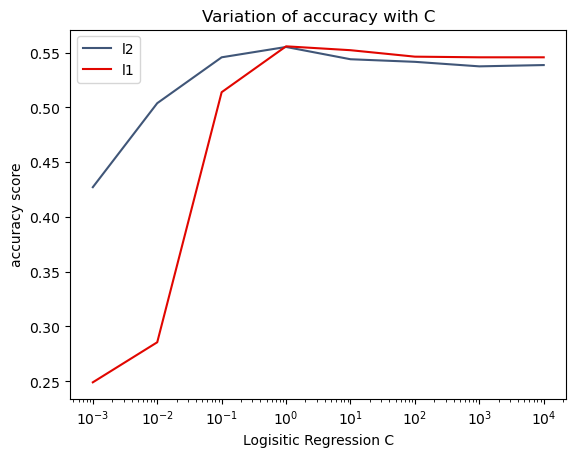

In [60]:
plt.figure()
sns.lineplot(data = fittedgrid_log.cv_results_ ,x ='param_log_reg__C', y='mean_test_score', hue='param_log_reg__penalty')
#plt.scatter(fittedgrid_log.cv_results_['param_log_reg__C'].data, fittedgrid_log.cv_results_['mean_train_score'],label='Train score')
plt.title('Variation of accuracy with C')
plt.ylabel('accuracy score')
plt.xlabel('Logisitic Regression C')
plt.xscale('log')
plt.legend()
plt.show()

In [61]:
print('Best Logisitic Regression quali position model accuracy_score on X test:',fittedgrid_log.best_estimator_.score(X_test_manual, ypos_test))

Best Logisitic Regression quali position model accuracy_score on X test: 0.5816326530612245


In [62]:
y_pred=fittedgrid_log.best_estimator_.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)

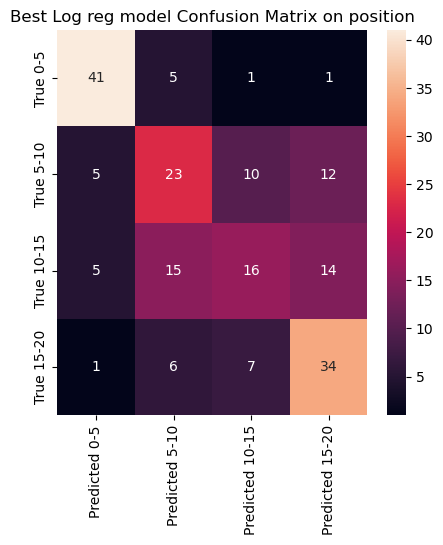

In [63]:
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Best Log reg model Confusion Matrix on position')
plt.show()

## Lap time delta

In [64]:
log_grid=[
    {
        'log_reg__solver': ['lbfgs'],
        'log_reg__penalty':['l2'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {
        'log_reg__solver': ['liblinear'],
        'log_reg__penalty':['l1'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
]

grid_log=GridSearchCV(log_pipe,log_grid,cv=5,verbose=1,return_train_score=True,n_jobs=-1)
fittedgrid_log=grid_log.fit(X_train_manual,ydelta_train)

print(fittedgrid_log.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'log_reg__C': 1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}


In [65]:
print(fittedgrid_log.best_params_)

{'log_reg__C': 1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}


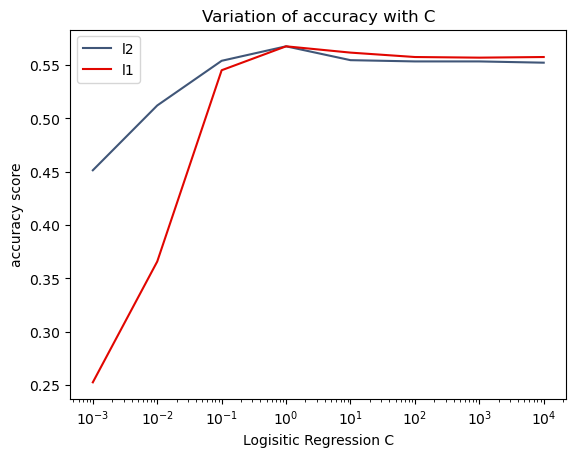

In [66]:
plt.figure()
sns.lineplot(data = fittedgrid_log.cv_results_ ,x ='param_log_reg__C', y='mean_test_score', hue='param_log_reg__penalty')
#plt.scatter(fittedgrid_log.cv_results_['param_log_reg__C'].data, fittedgrid_log.cv_results_['mean_train_score'],label='Train score')
plt.title('Variation of accuracy with C')
plt.ylabel('accuracy score')
plt.xlabel('Logisitic Regression C')
plt.xscale('log')
plt.legend()
plt.show()

In [67]:
print('Best Logisitic Regression lap delta model accuracy_score on X test:',fittedgrid_log.best_estimator_.score(X_test_manual, ydelta_test))

Best Logisitic Regression lap delta model accuracy_score on X test: 0.5816326530612245


In [68]:
y_pred=fittedgrid_log.best_estimator_.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

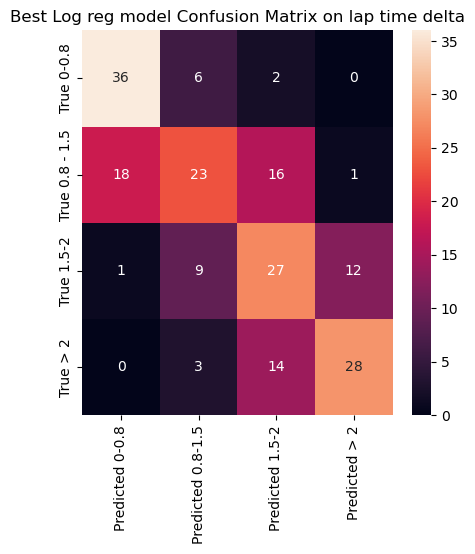

In [69]:
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best Log reg model Confusion Matrix on lap time delta')
plt.show()

## Features Selected with Select from Model


In [70]:
scale_cols, hot_encode_col = column_lists(X_train)

In [71]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('select_from_model',SelectFromModel(RandomForestClassifier())),
        ('log_reg',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

In [72]:
log_grid=[
    {   'select_from_model__threshold':['1.5*mean','1.8*mean','2.0*mean'],
        'log_reg__solver': ['lbfgs'],
        'log_reg__penalty':['l2'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {   'select_from_model__threshold':['2.0*mean'],
        'log_reg__solver': ['liblinear'],
        'log_reg__penalty':['l1'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
]

grid_log=GridSearchCV(log_pipe,log_grid,cv=5,verbose=1,return_train_score=True,n_jobs=-1)
fittedgrid_log=grid_log.fit(X_train,ypos_train)

print(fittedgrid_log.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'log_reg__C': 10, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs', 'select_from_model__threshold': '2.0*mean'}


In [73]:
print(fittedgrid_log.best_params_)

{'log_reg__C': 10, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs', 'select_from_model__threshold': '2.0*mean'}


In [74]:
print('Best Logisitic Regression position model accuracy_score on test data:',fittedgrid_log.best_estimator_.score(X_test, ypos_test))

Best Logisitic Regression position model accuracy_score on test data: 0.5714285714285714


In [75]:
y_pred=fittedgrid_log.best_estimator_.predict(X_test)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)

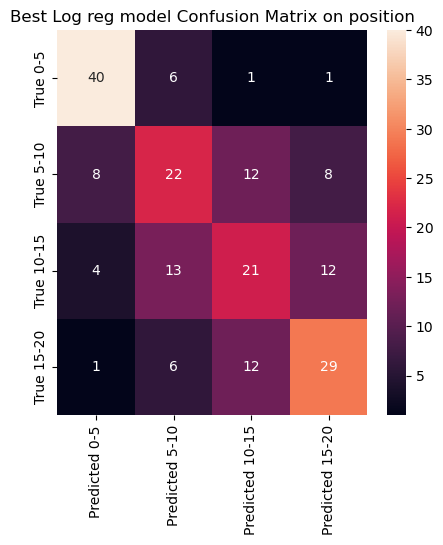

In [76]:
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Best Log reg model Confusion Matrix on position')
plt.show()

## Lap time delta

In [77]:
scale_cols, hot_encode_col = column_lists(X_train)

In [78]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('select_from_model',SelectFromModel(RandomForestClassifier())),
        ('log_reg',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

In [79]:
log_grid=[
    {   'select_from_model__threshold':['1.5*mean','1.8*mean','2.0*mean'],
        'log_reg__solver': ['lbfgs'],
        'log_reg__penalty':['l2'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {   'select_from_model__threshold':['2.0*mean'],
        'log_reg__solver': ['liblinear'],
        'log_reg__penalty':['l1'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
]

grid_log=GridSearchCV(log_pipe,log_grid,cv=5,verbose=1,return_train_score=True,n_jobs=-1)
fittedgrid_log=grid_log.fit(X_train,ydelta_train)

print(fittedgrid_log.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'log_reg__C': 0.1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear', 'select_from_model__threshold': '2.0*mean'}


In [80]:
print('Best Logisitic Regression lap delta model accuracy_score on X test:',fittedgrid_log.best_estimator_.score(X_test, ydelta_test))

Best Logisitic Regression lap delta model accuracy_score on X test: 0.5153061224489796


In [81]:
len(fittedgrid_log.best_estimator_[:-1].get_feature_names_out())

26

In [82]:
y_pred=fittedgrid_log.best_estimator_.predict(X_test)
log_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

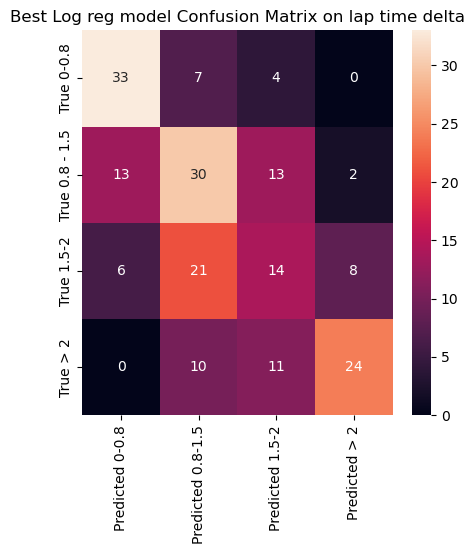

In [83]:
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best Log reg model Confusion Matrix on lap time delta')
plt.show()